# Prediksi Harga Saham PT Telekomunikasi Indonesia Tbk (TLKM.JK) Menggunakan LSTM

## Latar Belakang
PT Telekomunikasi Indonesia Tbk (TLKM) adalah perusahaan telekomunikasi terbesar di Indonesia.
Harga sahamnya menjadi indikator penting bagi investor yang ingin memantau perkembangan sektor ini.
Dengan bantuan algoritma *Long Short-Term Memory (LSTM)*, kita dapat memprediksi harga saham berdasarkan data historis.

# Import Library

Pertama, kita mengimpor pustaka-pustaka penting yang akan digunakan untuk analisis dan pemodelan:

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

## Memuat Dataset
Dataset berisi data historis harga saham TLKM dari tahun 2019 hingga 2024, termasuk harga pembukaan, penutupan, tertinggi, terendah, dan volume perdagangan.
Langkah pertama adalah memuat dataset dan menampilkannya sekilas.

In [2]:
# Upload kaggle.json yang didapatkan dari akun Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"naufalnurfahriza","key":"ec6f7ab7dabebc9fd0600384aa1880de"}'}

In [4]:
# Buat direktori dan ubah izin file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset dari Kaggle
!kaggle datasets download -d irfansaputranst/dataset-saham-tlkm-jk

# Unzip file ZIP hasil download
!unzip dataset-saham-tlkm-jk.zip

Dataset URL: https://www.kaggle.com/datasets/irfansaputranst/dataset-saham-tlkm-jk
License(s): DbCL-1.0
Archive:  dataset-saham-tlkm-jk.zip
  inflating: SAHAM - PT Telekomunikasi Indonesia Tbk (TLKM.JK) - Sheet1.csv  


## Statistik Deskriptif
Menampilkan informasi ringkas tentang jumlah data, tipe data, dan apakah ada nilai yang hilang.

In [6]:
df = pd.read_csv('SAHAM - PT Telekomunikasi Indonesia Tbk (TLKM.JK) - Sheet1.csv',
                 parse_dates=['Date'],
                 index_col='Date')

# Bersihkan kolom Volume
df['Volume'] = df['Volume'].str.replace('.', '', regex=False).astype(float)


### Deskripsi Statistik Data
Menampilkan statistik seperti mean, standar deviasi, min, dan max untuk memahami skala nilai pada setiap kolom.

Menampilkan Informasi Tiap Variabel

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1212 entries, 07/11/2019 to 06/11/2024
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1212 non-null   float64
 1   Close      1212 non-null   float64
 2   High       1212 non-null   float64
 3   Low        1212 non-null   float64
 4   Open       1212 non-null   float64
 5   Volume     1212 non-null   float64
dtypes: float64(6)
memory usage: 66.3+ KB


## Korelasi Antar Variabel
Menggunakan heatmap untuk mengidentifikasi hubungan antar fitur, seperti harga pembukaan, penutupan, tertinggi, terendah, dan volume.

In [8]:
df.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1.212000e+03
mean,3232.919909,3647.978548,3690.998350,3607.483498,3650.981848,1.161022e+08
std,506.366462,510.865708,508.614228,508.024318,508.843617,7.744300e+07
min,2070.660000,2560.000000,2590.000000,2450.000000,2550.000000,0.000000e+00
25%,2835.450000,3190.000000,3250.000000,3150.000000,3200.000000,6.933892e+07
50%,3228.050000,3720.000000,3765.000000,3690.000000,3720.000000,9.611110e+07
75%,3666.010000,4030.000000,4060.000000,3990.000000,4030.000000,1.395841e+08
max,4295.700000,4770.000000,4850.000000,4720.000000,4850.000000,1.155861e+09


Menampilkan Korelasi antar Variabel

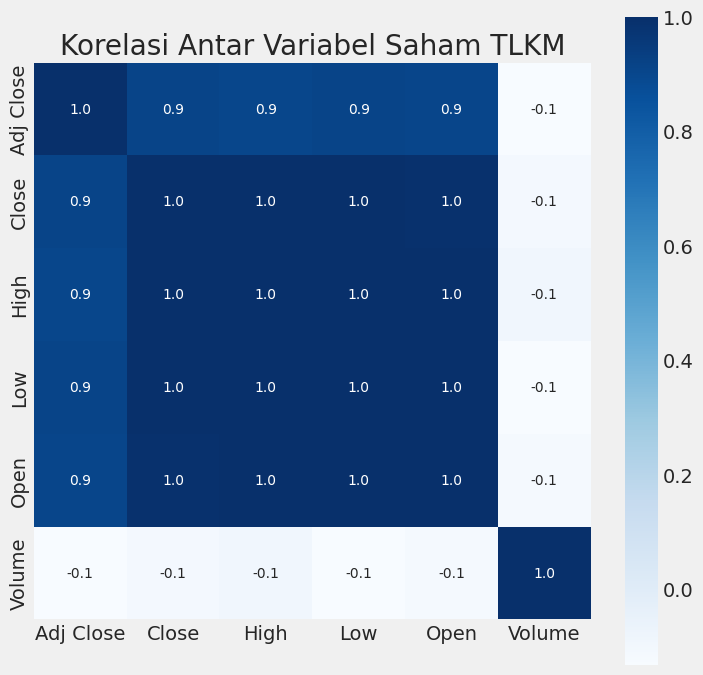

In [9]:
## Visualisasi Harga Saham TLKM
Menampilkan grafik pergerakan harga saham (High dan Low) dari waktu ke waktu untuk memahami tren dan volatilitas.

Visualisasi Harga Saham

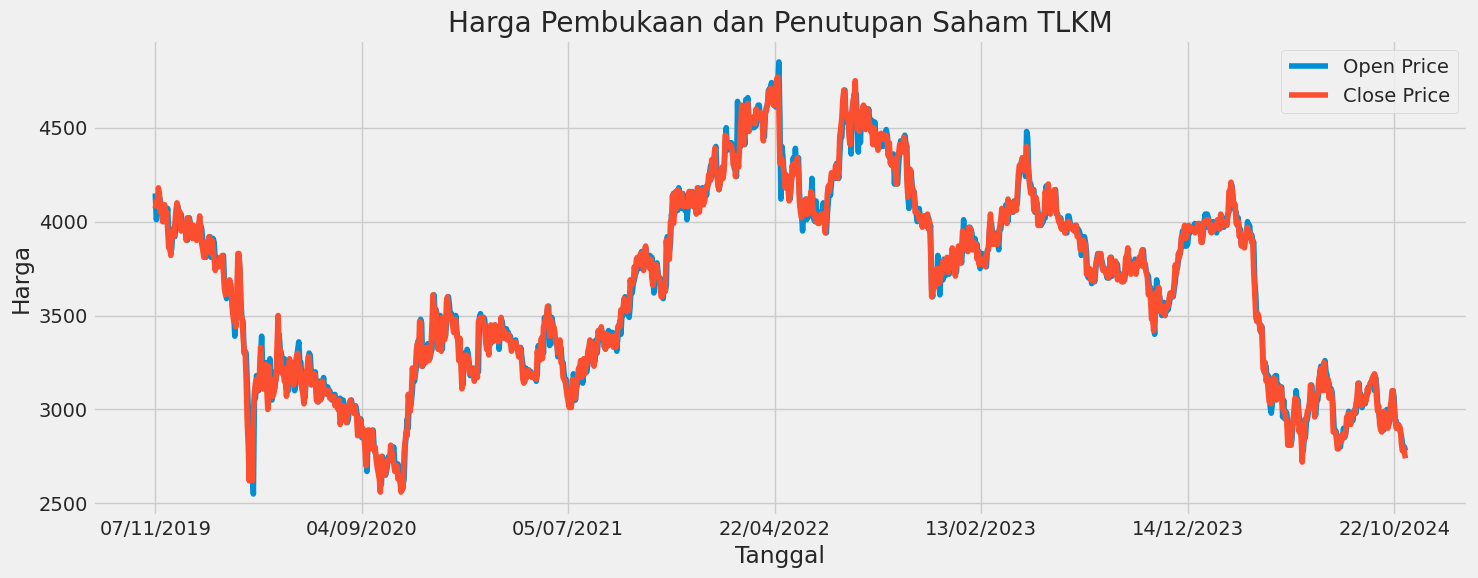

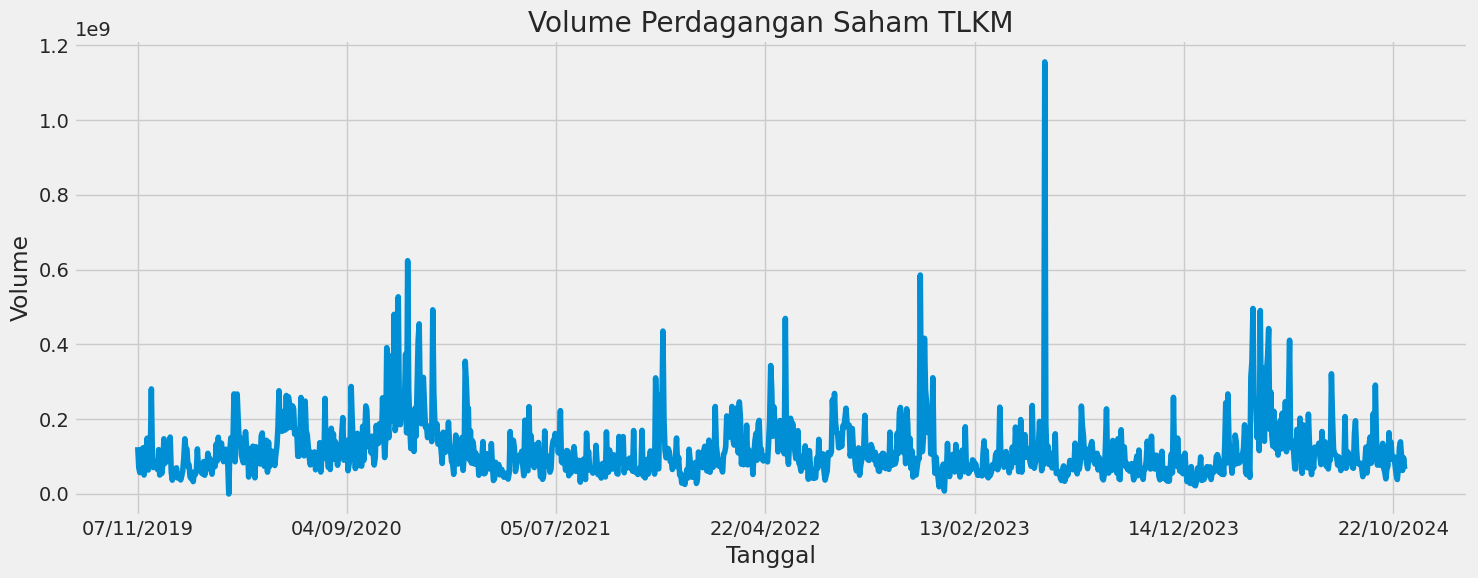

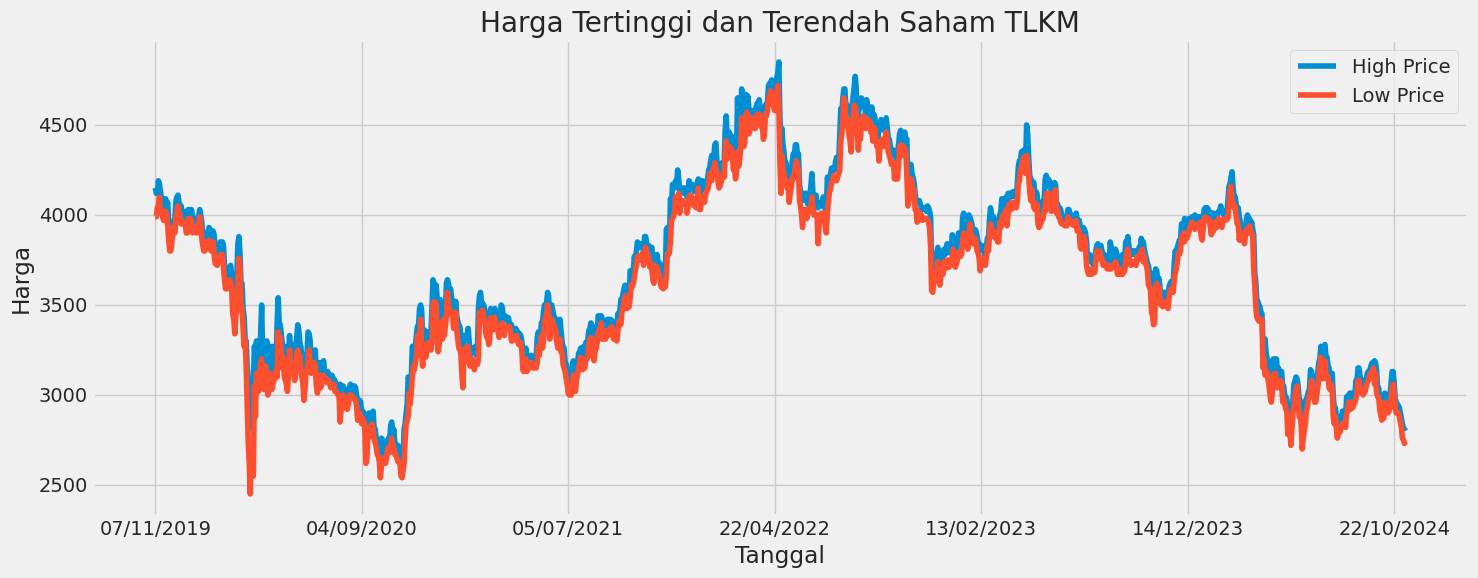

In [10]:
## Memilih Kolom yang Akan Diprediksi
Untuk model prediksi, kita memilih kolom `Close` karena mencerminkan harga penutupan saham tiap hari.

# Preprocessing The Data

## Normalisasi Data
Sebelum data digunakan pada model LSTM, data perlu dinormalisasi ke dalam rentang [0, 1] menggunakan MinMaxScaler.

In [11]:
dataset = df['Close']
dataset = pd.DataFrame(dataset)
data = dataset.values

## Pembagian Data
Dataset dibagi menjadi data latih (80%) dan data uji (20%) untuk melatih dan mengevaluasi performa model secara adil.

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

Membagi Data

In [13]:
## Membuat Dataset Pelatihan Berbasis Time Series
Model LSTM membutuhkan input berurutan. Maka, kita membuat window dengan 60 langkah waktu untuk memprediksi 1 nilai ke depan.

Train Size: 969
Test Size: 243


Membuat Training Set

In [14]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Menyiapkan Input untuk LSTM
Data diubah menjadi format 3 dimensi: `(samples, time_steps, features)` agar sesuai dengan input model LSTM.

Struktur Model

In [15]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=["mean_absolute_error"])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

## Arsitektur Model LSTM
Model LSTM terdiri dari 2 layer LSTM dengan Dropout di antaranya, serta beberapa layer Dense di akhir untuk prediksi regresi.

In [16]:
callbacks = [EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
history = model.fit(x_train, y_train, epochs=100, batch_size=128, callbacks=callbacks)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.1885 - mean_absolute_error: 0.3511
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0203 - mean_absolute_error: 0.1155
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0179 - mean_absolute_error: 0.1042
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0120 - mean_absolute_error: 0.0905
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0083 - mean_absolute_error: 0.0705
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0079 - mean_absolute_error: 0.0702
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0071 - mean_absolute_error: 0.0672
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0072 - mean_absolute_error: 0.0641
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0062 - mean_absolute_error: 0.0600
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0057 - mean_absolute_error: 0.0583
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/ste

# Evaluasi Model

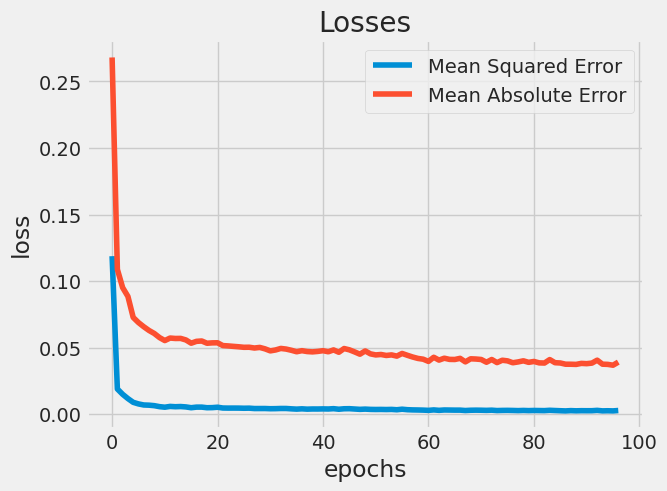

In [17]:
## Visualisasi Loss Selama Pelatihan
Menampilkan grafik Mean Squared Error (MSE) dan Mean Absolute Error (MAE) selama proses pelatihan untuk mengevaluasi performa.

#Prediksi

Membuat Testing Set

In [18]:
## Menyusun Dataset Pengujian
Membuat input dan target untuk data uji dengan struktur yang sama seperti data latih.

Prediksi dan Evaluasi

In [19]:
## Evaluasi dan Visualisasi Hasil Prediksi
Menggunakan data uji untuk membuat prediksi dan mengevaluasi performa model. Menampilkan grafik prediksi vs data aktual.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mean_absolute_error: 0.0290  
Loss: 0.0016474738949909806, MAE: 0.031798623502254486


Visualisasi Prediksi

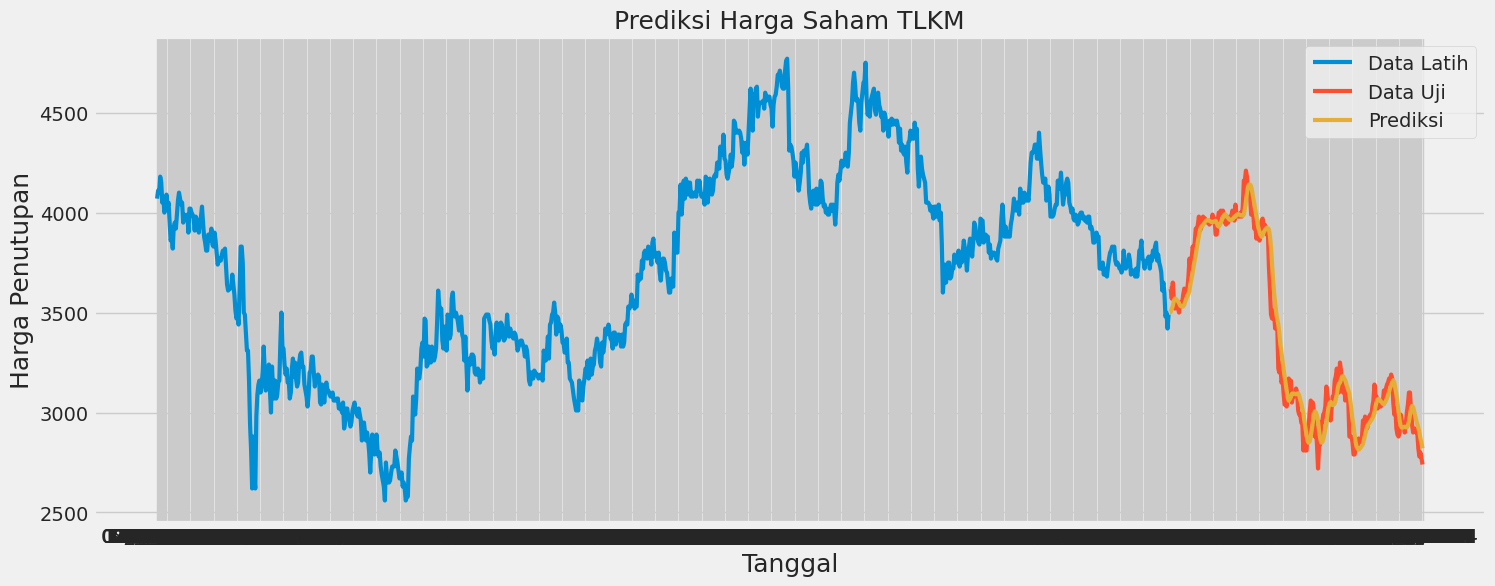

In [20]:
train = dataset.iloc[:train_size, 0:1]
test = dataset.iloc[train_size:, 0:1]
test['Predictions'] = predictions

plt.figure(figsize=(16, 6))
plt.title('Prediksi Harga Saham TLKM', fontsize=18)
plt.xlabel('Tanggal', fontsize=18)
plt.ylabel('Harga Penutupan', fontsize=18)
plt.plot(train['Close'], linewidth=3)
plt.plot(test['Close'], linewidth=3)
plt.plot(test["Predictions"], linewidth=3)
plt.legend(['Data Latih', 'Data Uji', 'Prediksi'])
plt.show()